## Flow to LAN distilation

__Goals:__ Combine the flexibility and training efficiency of normalizing flows with the inference efficiency of MLPs by distilling trained flow-based density estimator into a likelihood approximation network.


In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from functools import partial

import numpy as np
import torch as th
import jax.random as jrd
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm
import arviz as az
import pymc as pm

from copy import deepcopy
from torch import Tensor
from torch.utils.data import DataLoader, TensorDataset

from sbi.analysis import pairplot
from sbi.inference import MNLE
from sbi.utils import BoxUniform

from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

from lanfactory.trainers import MLPJax, ModelTrainerJaxMLP

import hssm
from hssm.config import ModelConfig
from hssm.distribution_utils.dist import make_distribution, make_hssm_rv, make_likelihood_callable
from hssm.utils import decorate_atomic_simulator

from ssms.basic_simulators.simulator import simulator as ssm_simulator


wandb not available
wandb not available


In [2]:
# Set random seeds for reproducibility
seed = 42
np.random.seed(seed)
th.manual_seed(seed)
key = jrd.PRNGKey(seed)

#### Step 1: Preparing the simulator

References: 
- https://github.com/lnccbrown/ssm-simulators/blob/main/notebooks/basic_tutorial.ipynb
- https://sbi-dev.github.io/sbi/v0.23.3/tutorials/00_getting_started/

In [3]:
def simulator(theta: Tensor) -> Tensor:
    """
    SBI expects simulator of that takes a tensor of param values [n_samples x param_dim]
      and return tensor of observations [n_samples x obs_dim].
    """
    xs = []
    for t in tqdm(theta):
        sim_out = ssm_simulator(
            model="ddm",
            theta={ "v": t[0].item(),
                    "a": t[1].item(),
                    "z": t[2].item(),
                    "t": t[3].item() },
            n_samples=1,
            smooth_unif=False,
        )
        rt = sim_out["rts"].squeeze()
        choice = sim_out["choices"].squeeze()

        # NOTE: there is some error when using [-1, 1] coding when training MNLE 
        # This should be fixed. For now, we convert to [0, 1] coding
        choice[choice == -1] = 0

        x = th.from_numpy(np.array([rt, choice]))
        xs.append(x)

    xs = th.stack(xs, dim=0).to(th.float32)
    return xs

In [4]:
# Define prior bounds on the parameters [v, a, z, t]
param_lower_bounds = th.tensor([-3.0, 0.3, 0.1, 0.0])
param_upper_bounds = th.tensor([3.0, 2.5, 0.9, 2.0])
prior = BoxUniform(low=param_lower_bounds, high=param_upper_bounds)

In [5]:
# validate simulator and prior
prior, num_parameters, prior_returns_numpy = process_prior(prior)

# Check simulator, returns PyTorch simulator able to simulate batches.
simulator = process_simulator(simulator, prior, prior_returns_numpy)

# Consistency check after making ready for sbi.
check_sbi_inputs(simulator, prior)

100%|██████████| 1/1 [00:00<00:00, 877.10it/s]


#### Step 2: Train density estimator using SBI 

References: 
- https://sbi-dev.github.io/sbi/v0.23.3/tutorials/00_getting_started/
- https://sbi-dev.github.io/sbi/v0.24.0/tutorials/Example_01_DecisionMakingModel/
- https://github.com/mackelab/mnle-for-ddms

In [6]:
# Generate MNLE training data
num_sims_train = 100000
theta_train = prior.sample((num_sims_train,))
x_train = simulator(theta_train)

# Train MNLE 
trainer = MNLE(prior=prior)

100%|██████████| 100000/100000 [00:28<00:00, 3516.31it/s]


In [7]:
%%time

# Train MNLE
estimator = trainer.append_simulations(theta_train, x_train).train()

print('\nMNLE training time:')

 Neural network successfully converged after 90 epochs.
MNLE training time:
CPU times: user 5min 32s, sys: 2min 27s, total: 8min
Wall time: 5min 57s


In [8]:
# Define theta obersvation for validation
theta_obs = th.tensor([[1.0, 1.5, 0.5, 0.3]])

In [9]:
# Test the likelihood by comparing emulator and simulator, for a known theta
synthetic_data = estimator.sample(sample_shape=(1000,), condition=theta_obs)
real_data = simulator(theta_obs.repeat(1000, 1))

# Fix the shapes of the sythentic data
synthetic_data = synthetic_data[:,0,:]
print('real_data.shape: ', real_data.shape)
print('synthetic data.shape: ', synthetic_data.shape)

100%|██████████| 1000/1000 [00:00<00:00, 2642.31it/s]

real_data.shape:  torch.Size([1000, 2])
synthetic data.shape:  torch.Size([1000, 2])


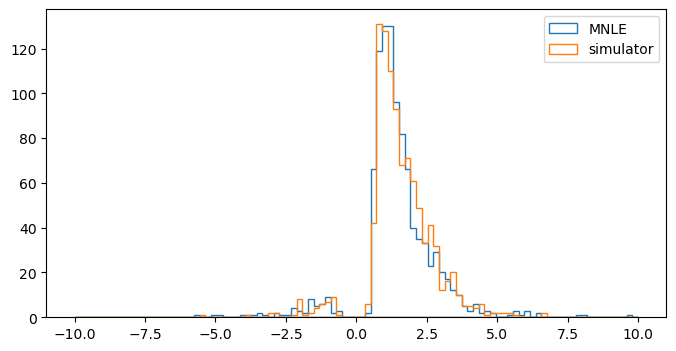

In [10]:
# Compare the histograms from real and sythetic data
plt.figure(figsize=(8, 4))
bins = th.linspace(-10, 10, 100)

synthetic_choice_mask = synthetic_data[:, 1] == 0
real_choice_mask = real_data[:, 1] == 0

plt.hist(-synthetic_data[synthetic_choice_mask, 0], bins=bins, histtype="step");
plt.hist(-real_data[real_choice_mask, 0], bins=bins, histtype="step");
plt.legend(["MNLE", "simulator"])
plt.hist(synthetic_data[~synthetic_choice_mask, 0], bins=bins, histtype="step", 
         color="C0");
plt.hist(real_data[~real_choice_mask, 0], bins=bins, histtype="step", 
         color="C1");

plt.show()

In [11]:
# Define MCMC parameters
mcmc_kwargs = dict(
    num_chains=10,
    warmup_steps=100,
    method="slice_np_vectorized",
    init_strategy="proposal",
)

# Build posterior from the trained estimator and prior.
mnle_posterior = trainer.build_posterior(prior=prior)

In [12]:
# Test parameter recovery
n_posterior_samples = 10000

# Define parameters, simulate observation
x_obs = simulator(theta_obs)
mnle_posterior.set_default_x(x_obs);

100%|██████████| 1/1 [00:00<00:00, 933.10it/s]


In [13]:
%%time

# Get posterior samples and MAP estimate
samples = mnle_posterior.sample((n_posterior_samples,))

print('\nMNLE posterior sampling time: ')

Generating 20 MCMC inits via resample strategy:   0%|          | 0/20 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/15000 [00:00<?, ?it/s]


MNLE posterior sampling time: 
CPU times: user 56.4 s, sys: 32.2 s, total: 1min 28s
Wall time: 42.6 s


In [14]:
map = mnle_posterior.map().squeeze()

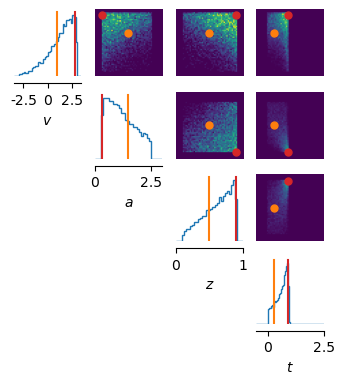

In [15]:
# Generate pair plot of posterior along with true and MAP parameters
lower_bounds = th.tensor([-3.5, 0, 0, -.5])
upper_bounds = th.tensor([3.5, 3, 1, 2.5])

fig, ax = pairplot(samples,
             limits=list(zip(lower_bounds, upper_bounds)),
             figsize=(4, 4),
             labels=[r"$v$", r"$a$", r"$z$", r"$t$"], 
             points=[theta_obs, map],
             );

/var/folders/px/fw8yx6952d98rglp3pvmk66w0000gn/T/ipykernel_75707/1333950313.py:2: DeprecationWarning: you passed deprecated arguments **kwargs: ['kde_offdiag', 'kde_diag', 'contour_offdiag'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig, ax = pairplot([


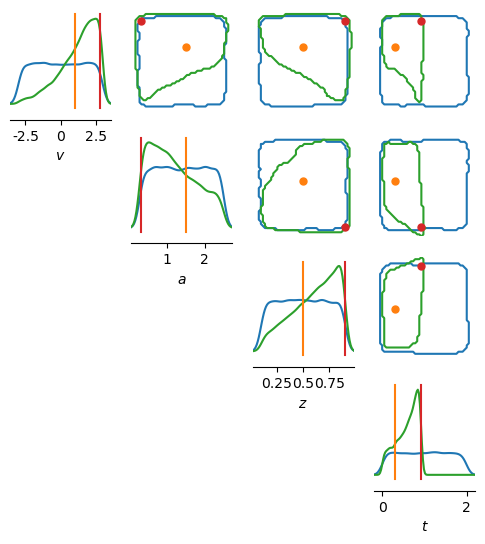

In [16]:
# Now plot pairplot with contours (obtained via KDE on the samples).
fig, ax = pairplot([
    prior.sample((10000,)),
    samples,
], 
    figsize=(6, 6),
    diag="kde",
    upper="contour", 
    kde_offdiag=dict(bins=50),
    kde_diag=dict(bins=100),
    contour_offdiag=dict(levels=[0.95]),
    labels=[r"$v$", r"$a$", r"$z$", r"$t$"], 
    points=[theta_obs, map],
);

#### Step 3: Distill flow into LAN

References:
- https://github.com/lnccbrown/LANfactory
- https://github.com/lnccbrown/LANfactory/blob/main/notebooks/basic_tutorial_jax_lan.ipynb

In [17]:
print(theta_train.shape)
print(x_train.shape)

torch.Size([100000, 4])
torch.Size([100000, 2])


In [18]:
# Get log prob evaluation for all the training data. These are the labels for the distillation.
with th.no_grad():
    log_p = estimator.log_prob(x_train.unsqueeze(0), condition=theta_train).squeeze(0)

# Convert back to [-1, 1] coding for LAN training
x_train_lan = deepcopy(x_train) 
x_train_lan[:, 1][x_train_lan[:, 1] == 0] = -1

# LANs learn the function f: [x, theta] -> log p(x | theta).
data = th.concat((theta_train, x_train_lan), dim=1)
labels = log_p.reshape(-1, 1)

In [19]:
print(data.shape)
print(labels.shape)

torch.Size([100000, 6])
torch.Size([100000, 1])


In [20]:
# Build DataLoaders
batch_size = 128
ds = TensorDataset(data, labels)
train_dl = DataLoader(ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(ds, batch_size=batch_size, shuffle=False)

# Tell the trainer how big each input is
train_dl.dataset.input_dim = data.shape[1]
valid_dl.dataset.input_dim = data.shape[1]

# Dummy placeholders so that .train_and_evaluate doesn’t crash on saving
train_dl.dataset.data_generator_config = {}
valid_dl.dataset.data_generator_config = {}
train_dl.dataset.file_ids = []
valid_dl.dataset.file_ids = []


# Train jax MLP with lanfactory
train_config = {"n_epochs": 50, "loss": "mse"}

mlp = MLPJax(
    layer_sizes=(64,64,1), 
    activations = ("relu","relu","linear"), 
    train=True, 
    train_output_type="logprob"
)

trainer = ModelTrainerJaxMLP(
    train_config, 
    mlp, 
    train_dl, 
    valid_dl, 
    seed=0
)

In [21]:
%%time

# Train LAN
final_state = trainer.train_and_evaluate(    
    output_folder="./jax_mlp_runs",
    output_file_id="lan_mlp",
    run_id="run1",
    wandb_on=False,
    save_all=False,
)

print('\nLAN training time: ')

Found folder:  .
Moving on...
Found folder:  ./jax_mlp_runs
Moving on...
Epoch: 0 of 50
Training - Step: 0 of 782 - Loss: 1.1506506
Epoch 0/50 time: 0.3835608959197998s
Validation - Step: 0 of 782 - Loss: 0.318037
Epoch 0/50 time: 0.2350161075592041s
Epoch: 0 / 50, test_loss: 1.1821157932281494
Epoch: 1 of 50
Training - Step: 0 of 782 - Loss: 0.21053699
Epoch 1/50 time: 0.2505159378051758s
Validation - Step: 0 of 782 - Loss: 0.24209842
Epoch 1/50 time: 0.20055174827575684s
Epoch: 1 / 50, test_loss: 0.9609879851341248
Epoch: 2 of 50
Training - Step: 0 of 782 - Loss: 0.6707926
Epoch 2/50 time: 0.2518749237060547s
Validation - Step: 0 of 782 - Loss: 0.18975157
Epoch 2/50 time: 0.2069377899169922s
Epoch: 2 / 50, test_loss: 0.8145864605903625
Epoch: 3 of 50
Training - Step: 0 of 782 - Loss: 0.18966216
Epoch 3/50 time: 0.2544138431549072s
Validation - Step: 0 of 782 - Loss: 0.2039535
Epoch 3/50 time: 0.2039029598236084s
Epoch: 3 / 50, test_loss: 0.7429817914962769
Epoch: 4 of 50
Training - S

#### Step 4: posterior inference using HSSM

References: 
- https://github.com/lnccbrown/HSSM
- https://lnccbrown.github.io/HSSM/tutorials/jax_callable_contribution_onnx_example/

In [22]:
jax_logp, _ = mlp.make_forward_partial(
    seed=seed,
    input_dim=4 + 2,  # n-parameters (v,a,z,t) + n-data (rts and choices)
    state="./jax_mlp_runs/run1_lan_lan_mlp__train_state.jax",
    add_jitted=True,
)

In [23]:
# Testing the signature of the JAX function 1
n_trials = 10
jax_logp(np.tile(np.array([1.0, 1.5, 0.5, 0.3, 1.6, 1.0]), (n_trials, 1)))

Array([[-0.58560248],
       [-0.58560248],
       [-0.58560248],
       [-0.58560248],
       [-0.58560248],
       [-0.58560248],
       [-0.58560248],
       [-0.58560248],
       [-0.58560248],
       [-0.58560248]], dtype=float64)

In [24]:
# Testing the signature of the JAX function 2
n_dim_model_parameters = 4
n_dim_data = 2
in_ = jnp.zeros((n_trials, n_dim_model_parameters + n_dim_data))
out = jax_logp(in_)
print(out.shape)

(10, 1)


In [25]:
def sim_wrapper(simulator_fun, theta, model, n_samples, random_state, **kwargs):
    """ Wrap a simulator function to match HSSM's expected interface. """
    out = simulator_fun(
        theta=theta,
        model=model,
        n_samples=n_samples,
        random_state=random_state,
        **kwargs,
    )
    return np.column_stack([out["rts"], out["choices"]])

my_wrapped_simulator = partial(
    sim_wrapper, simulator_fun=ssm_simulator, model="ddm", n_samples=1
)

decorated_simulator = decorate_atomic_simulator(
    model_name="ddm", choices=[-1, 1], obs_dim=2
)(my_wrapped_simulator)

In [26]:
decorated_simulator(
    theta=np.tile(np.array([1.0, 1.5, 0.5, 0.3]), (10, 1)), random_state=42
)

array([[ 2.12210941,  1.        ],
       [ 2.6890626 ,  1.        ],
       [ 1.28667963,  1.        ],
       [ 1.16390681,  1.        ],
       [ 1.42591691,  1.        ],
       [ 1.14748347,  1.        ],
       [ 1.47392309,  1.        ],
       [ 0.88049531, -1.        ],
       [ 1.78516912,  1.        ],
       [ 1.20256472,  1.        ]])

In [27]:
# Define a pytensor RandomVariable
CustomRV = make_hssm_rv(
    simulator_fun=decorated_simulator, list_params=["v", "a", "z", "t"]
)

# Define a likelihood function
logp_jax_op = make_likelihood_callable(
    loglik=jax_logp,
    loglik_kind="approx_differentiable",
    backend="jax",
    params_is_reg=[False, False, False, False],
    params_only=False,
)

# Define a distribution
CustomDistribution = make_distribution(
    rv=CustomRV,
    loglik=logp_jax_op,
    list_params=["v", "a", "z", "t"],
    bounds=dict(v=(-3, 3), a=(0.5, 3.0), z=(0.1, 0.9), t=(0, 2.0)),
)

In [28]:
mcmc_kwargs

{'num_chains': 10,
 'warmup_steps': 100,
 'method': 'slice_np_vectorized',
 'init_strategy': 'proposal'}

In [29]:
# simulate some data from the model
obs_ddm = hssm.simulate_data(
    theta = dict(
            v=theta_obs[0][0].item(), 
            a=theta_obs[0][1].item(),     
            t=theta_obs[0][2].item(), 
            z=theta_obs[0][3].item()
    ), 
    model="ddm", 
    size=10
)

# Test via basic pymc model
with pm.Model() as model:
    v = pm.Normal("v", mu=0, sigma=1)
    a = pm.Uniform("a", lower=0.5, upper=3.0)
    z = pm.Beta("z", alpha=10, beta=10)
    t = pm.Weibull("t", alpha=0.5, beta=1.0)
    CustomDistribution("custom", v=v, a=a, z=z, t=t, observed=obs_ddm.values)
    
with model:
    idata = pm.sample(draws=n_posterior_samples, tune=100, chains=10, nuts_sampler="numpyro")

sample: 100%|██████████| 10100/10100 [00:05<00:00, 1956.75it/s, 31 steps of size 7.75e-02. acc. prob=0.90]


array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 't'}>, <Axes: title={'center': 't'}>],
       [<Axes: title={'center': 'v'}>, <Axes: title={'center': 'v'}>],
       [<Axes: title={'center': 'z'}>, <Axes: title={'center': 'z'}>]],
      dtype=object)

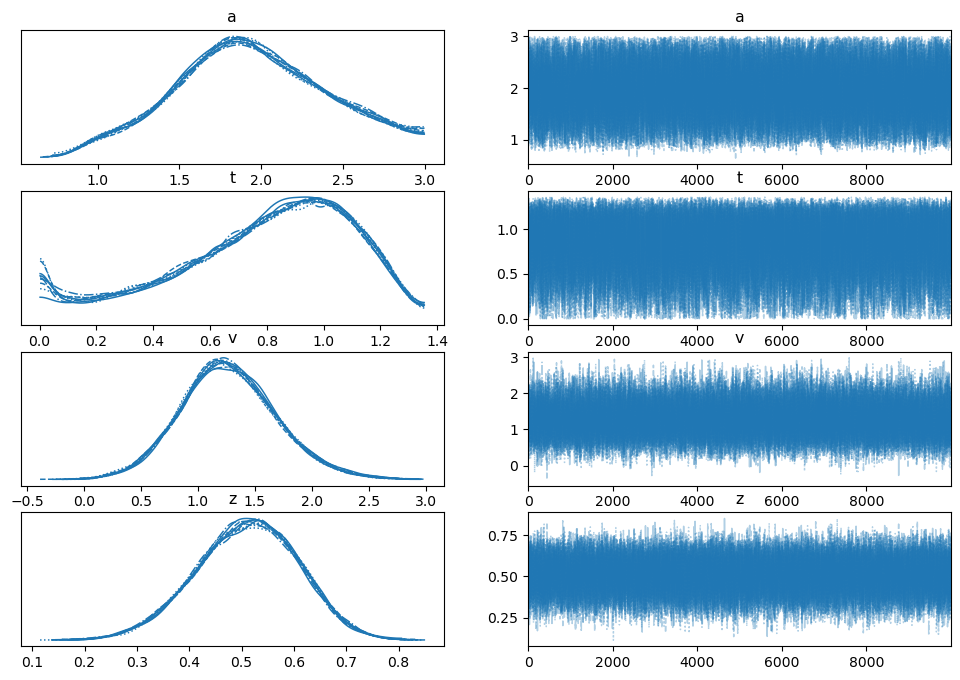

In [ ]:
az.plot_trace(idata);

In [31]:
# Define model config
my_custom_model_config = ModelConfig(
    response=["rt", "response"],
    list_params=["v", "a", "z", "t"],
    bounds={
        "v": (-2.5, 2.5),
        "a": (1.0, 3.0),
        "z": (0.0, 0.9),
        "t": (0.001, 2),
    },
    rv=decorated_simulator,
    backend="jax",
    choices=[-1, 1],
)

You have specified the `lapse` argument to include a lapse distribution, but `p_outlier` is set to either 0 or None. Your lapse distribution will be ignored.
You set choices to be [-1, 1], but [-1] are missing from your dataset.
Model initialized successfully.


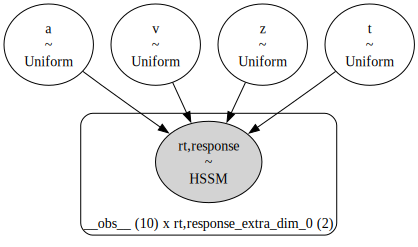

In [32]:
# Define the HSSM model
model = hssm.HSSM(
    data=obs_ddm,
    model="lan_distillation",  
    model_config=my_custom_model_config,
    loglik_kind="approx_differentiable",  # use the blackbox loglik
    loglik=jax_logp,
    p_outlier=0,
)

model.graph()

In [33]:
%%time

# Test sampling
model.sample(draws=n_posterior_samples, tune=100, chains=10, nuts_sampler="numpyro", discard_tuned_samples=False)

print('\nHSSM sampling time: ')

Using default initvals. 



sample: 100%|██████████| 10100/10100 [00:08<00:00, 1196.95it/s, 31 steps of size 5.25e-02. acc. prob=0.94]
/Users/hayden/miniconda3/envs/lans/lib/python3.11/site-packages/pymc/pytensorf.py:958: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(
100%|██████████| 100000/100000 [00:04<00:00, 22173.72it/s]


HSSM sampling time: 
CPU times: user 1min 4s, sys: 16.6 s, total: 1min 21s
Wall time: 52.3 s


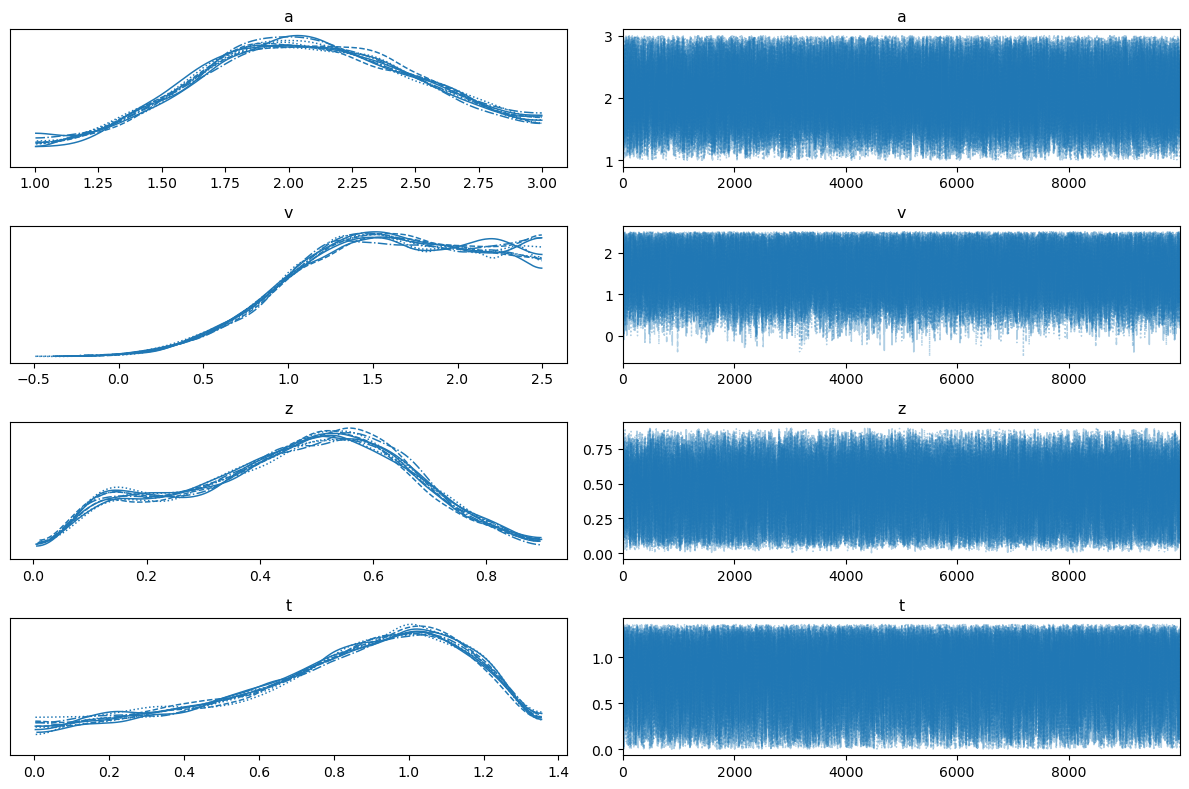

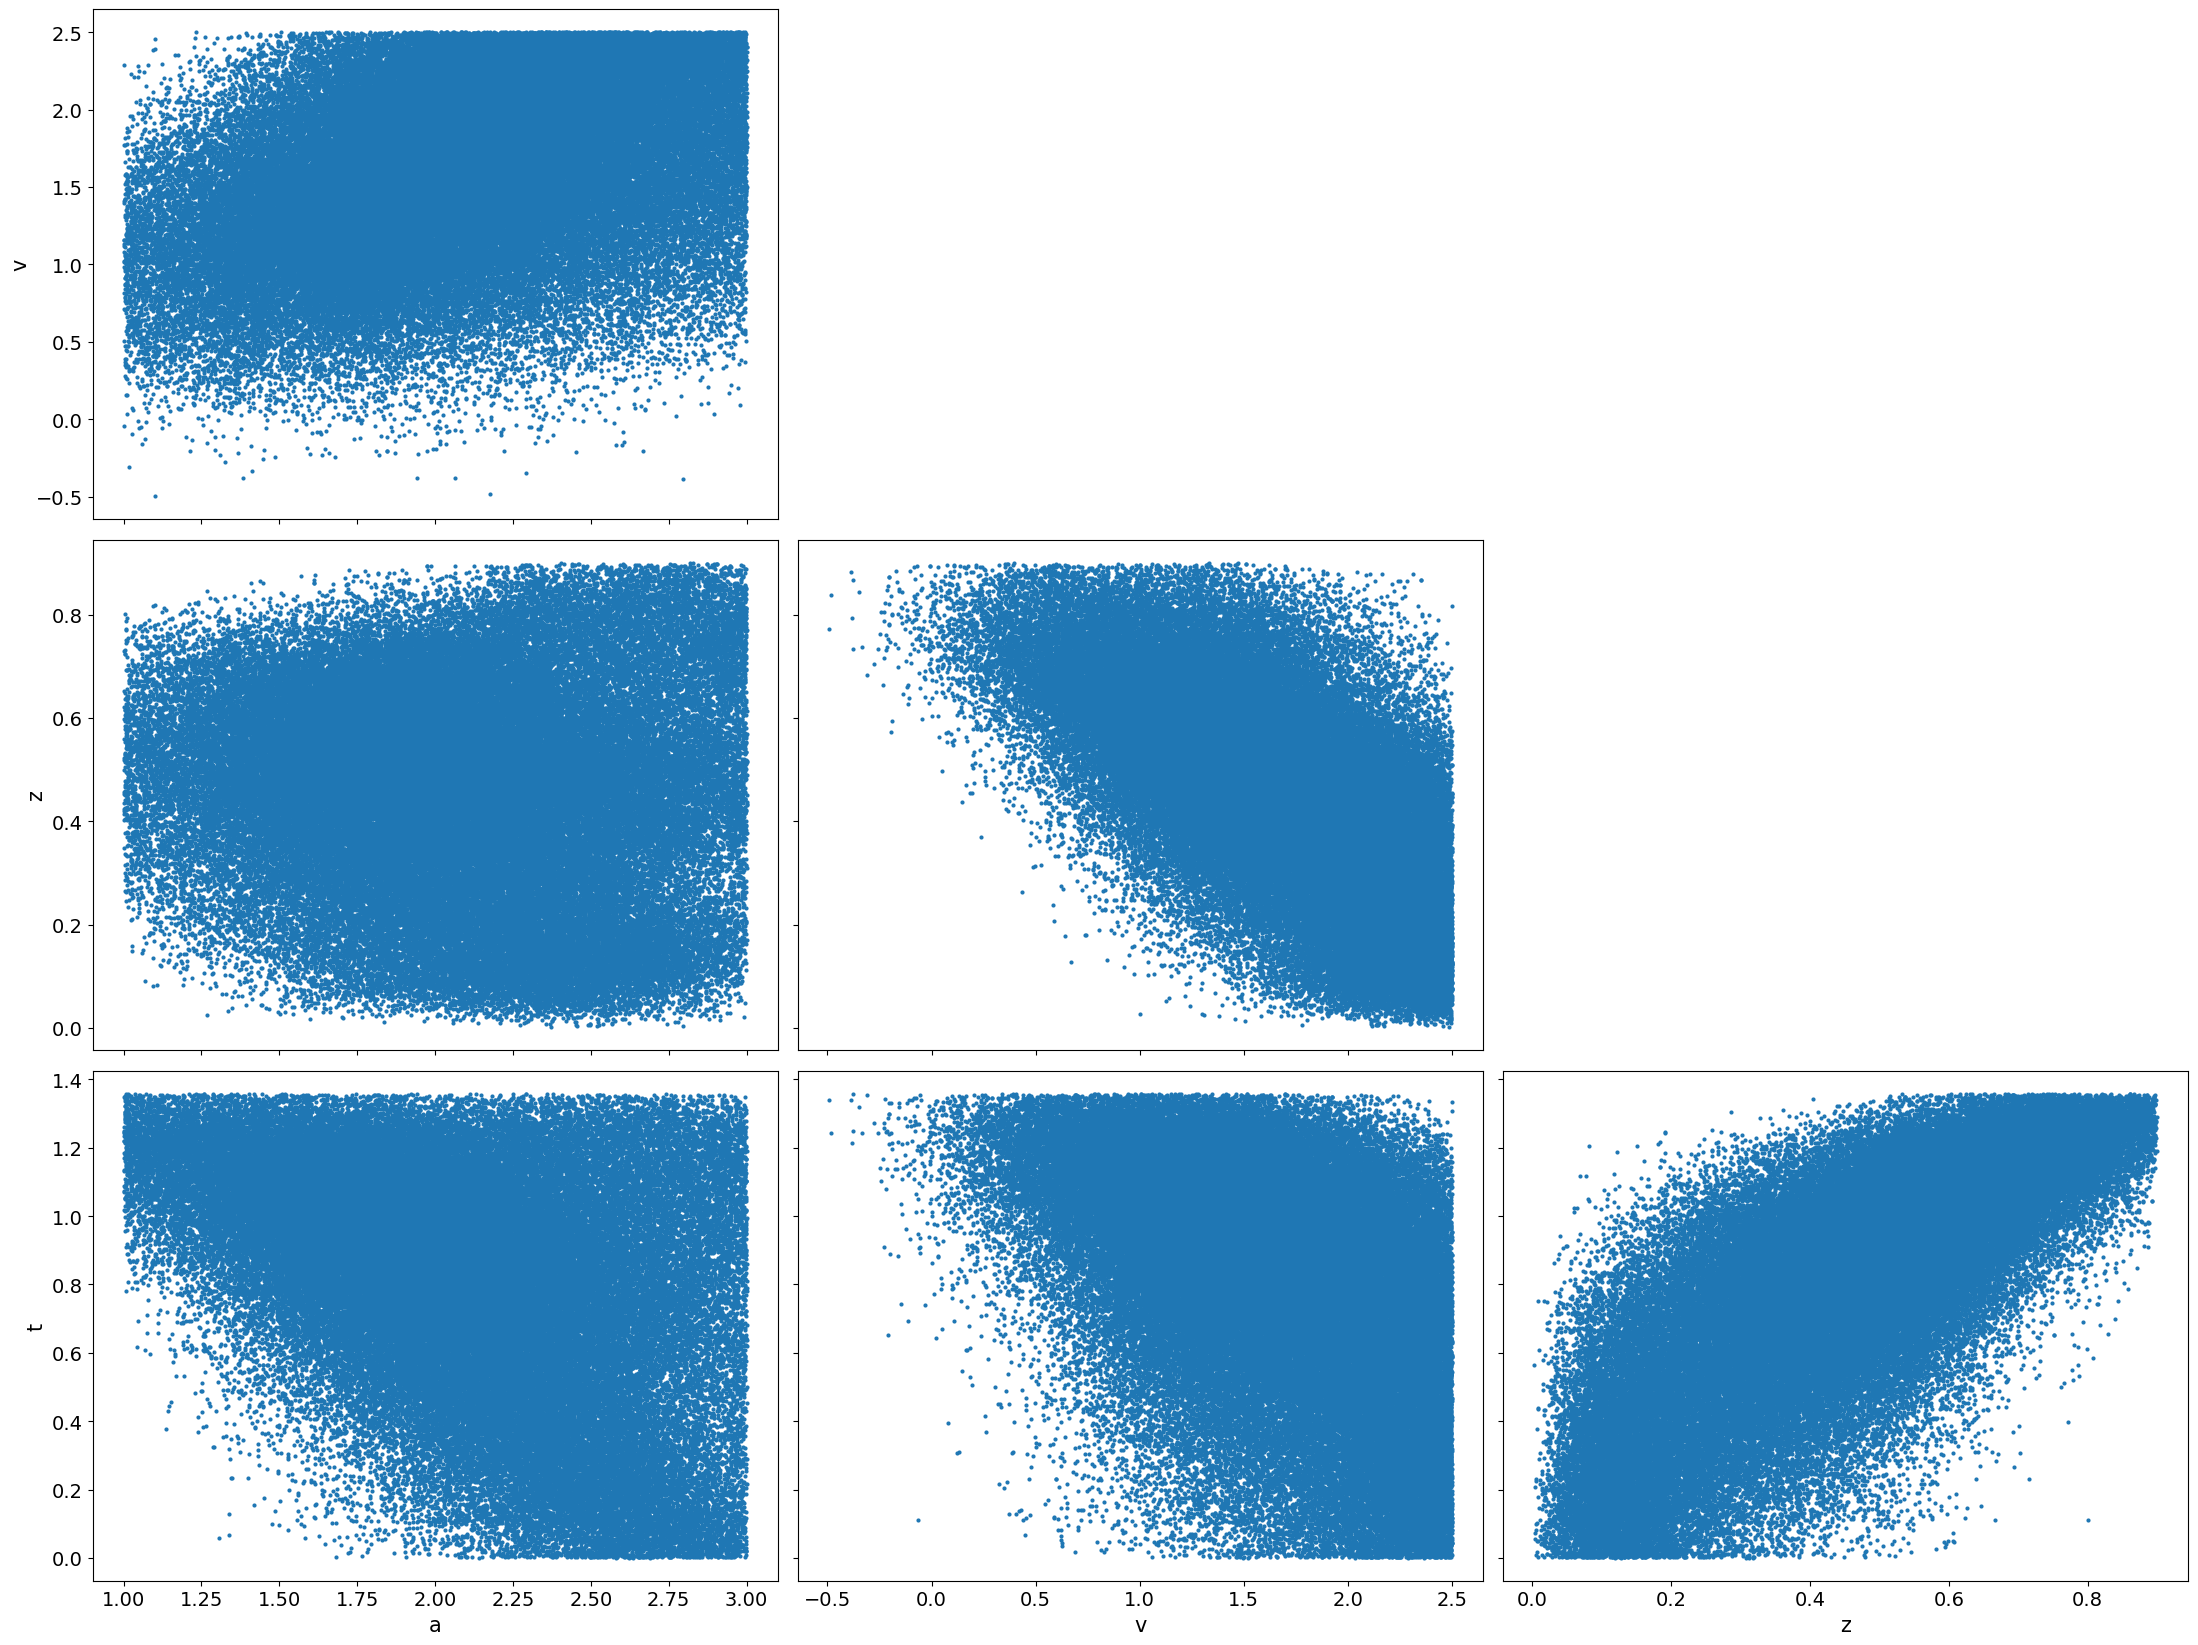

In [34]:
az.plot_trace(model.traces)
plt.tight_layout()

az.plot_pair(model.traces)
plt.tight_layout()